In [1]:
%load_ext autoreload
%autoreload 2

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import json
import datetime
from collections import OrderedDict

from models.seir_testing import SEIR_Testing

In [90]:
data = requests.get('https://api.rootnet.in/covid19-in/stats/history').json()
columns = ['confirmedCasesForeign', 'confirmedCasesIndian', 'deaths', 'discharged', 'loc', 'date']
df = pd.DataFrame(columns=columns)
for i, data_json in enumerate(data['data']):
    df_temp = pd.DataFrame.from_dict(data['data'][i]['regional'])
    df_temp['date'] = data['data'][i]['day']
    df = pd.concat([df, df_temp])
    
df['confirmedCases'] = df['confirmedCasesForeign'] + df['confirmedCasesIndian']
df['date'] = pd.to_datetime(df['date'])

In [91]:
df_maha = df[df['loc'] == 'Maharashtra']
df_maha.reset_index(drop=False)

,index,confirmedCasesForeign,confirmedCasesIndian,deaths,discharged,loc,date,confirmedCases
0,4,0,2,0,0,Maharashtra,2020-03-10,2
1,4,0,2,0,0,Maharashtra,2020-03-11,2
2,4,0,11,0,0,Maharashtra,2020-03-12,11
3,5,0,14,0,0,Maharashtra,2020-03-13,14
4,5,0,14,0,0,Maharashtra,2020-03-14,14
5,5,0,32,0,0,Maharashtra,2020-03-15,32
6,5,0,32,0,0,Maharashtra,2020-03-16,32
7,5,3,36,1,0,Maharashtra,2020-03-17,39
8,5,3,39,1,0,Maharashtra,2020-03-18,42
9,6,3,44,1,0,Maharashtra,2020-03-19,47


In [5]:
# define SEIR model parameters (Gabriel Goh's version)
def init_params(R0 = 2.2, T_inf = 2.9, T_inc = 5.2, T_hosp = 5, T_death = 32, P_severe = 0.2, P_fatal = 0.02, N = 7e6, 
                init_infected = 1, intervention_day = 100, intervention_amount = 3, testing_rate_for_exposed = 0,
                positive_test_rate_for_exposed = 1, testing_rate_for_infected = 0, positive_test_rate_for_infected = 1, q = 0):
    
    T_trans = T_inf/R0
    T_recov_mild = (14 - T_inf)
    T_recov_severe = (31.5 - T_inf)
    
    P_mild = 1 - P_severe - P_fatal

    # define testing related parameters
    T_inf_detected = T_inf
    T_trans_detected = T_trans
    T_inc_detected = T_inc

    P_mild_detected = P_mild
    P_severe_detected = P_severe
    P_fatal_detected = P_fatal

    vanilla_params = {
        'T_trans': T_trans,
        'T_inc': T_inc,
        'T_inf': T_inf,

        'T_recov_mild': T_recov_mild,
        'T_recov_severe': T_recov_severe,
        'T_hosp': T_hosp,
        'T_death': T_death,

        'P_mild': P_mild,
        'P_severe': P_severe,
        'P_fatal': P_fatal,
        'intervention_day': intervention_day,
        'intervention_amount': intervention_amount,
        'N' : N
    }

    testing_params = {
        'T_trans': T_trans_detected,
        'T_inc': T_inc_detected,
        'T_inf': T_inf_detected,

        'P_mild': P_mild_detected,
        'P_severe': P_severe_detected,
        'P_fatal': P_fatal_detected,

        'q': q,
        'testing_rate_for_exposed': testing_rate_for_exposed,
        'positive_test_rate_for_exposed': positive_test_rate_for_exposed,
        'testing_rate_for_infected': testing_rate_for_infected,
        'positive_test_rate_for_infected': positive_test_rate_for_infected
    }

    # S, E, D_E, D_I, I, R_mild, R_severe_home, R_severe_hosp, R_fatal, C, D
    state_init_values = OrderedDict()
    state_init_values['S'] = (N - init_infected)/N
    state_init_values['E'] = 0
    state_init_values['I'] = init_infected/N
    state_init_values['D_E'] = 0
    state_init_values['D_I'] = 0
    state_init_values['R_mild'] = 0
    state_init_values['R_severe_home'] = 0
    state_init_values['R_severe_hosp'] = 0
    state_init_values['R_fatal'] = 0
    state_init_values['C'] = 0
    state_init_values['D'] = 0
    
    return vanilla_params, testing_params, state_init_values

In [7]:
def create_plots(sol, states_time_matrices, labels, last_time=26, savefig=False, filenames=None):
    ind = sol.t[:last_time]
    
    plt.figure(figsize=(12, 12))
    for i, states_time_matrix in enumerate(states_time_matrices):
        plt.plot(ind, states_time_matrix[2], label=labels[i])
    plt.ylabel('No of people')
    plt.xlabel('Days')
    plt.legend()
    plt.title("Number of undetected people spreading the disease")
    if not savefig:
        plt.show()
    else:
        plt.savefig('../{}'.format(filenames[0]))


    plt.figure(figsize=(12, 12))
    for i, states_time_matrix in enumerate(states_time_matrices):
        plt.plot(ind, states_time_matrix[3] + states_time_matrix[4], label=labels[i])
    plt.ylabel('No of people')
    plt.xlabel('Days')
    plt.legend()
    plt.title("Number of quarantined people")
    if not savefig:
        plt.show()
    else:
        plt.savefig('../{}'.format(filenames[1]))

    plt.figure(figsize=(12, 12))
    for i, states_time_matrix in enumerate(states_time_matrices):
        plt.plot(ind, states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
                 states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8], label=labels[i])
    plt.ylabel('No of people')
    plt.xlabel('Days')
    plt.legend()
    plt.suptitle("Number of active infections as a function of time")
    if not savefig:
        plt.show()
    else:
        plt.savefig('../{}'.format(filenames[2]))

    plt.figure(figsize=(12, 12))
    for i, states_time_matrix in enumerate(states_time_matrices):
        plt.plot(ind, states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
                 states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
                 states_time_matrix[9] + states_time_matrix[10], label=labels[i])
    plt.ylabel('No of people')
    plt.xlabel('Days')
    plt.legend()
    plt.title("Total No of infections (Active + Recovered + Dead)")
    if not savefig:
        plt.show()
    else:
        plt.savefig('../{}'.format(filenames[3]))

    plt.figure(figsize=(12, 12))
    for i, states_time_matrix in enumerate(states_time_matrices):
        plt.plot(ind, states_time_matrix[7] + states_time_matrix[8], label=labels[i])
    plt.ylabel('No of people')
    plt.xlabel('Days')
    plt.legend()
    plt.title("Number of hospitalisations")
    if not savefig:
        plt.show()
    else:
        plt.savefig('../{}'.format(filenames[4]))


    plt.figure(figsize=(12, 12))
    for i, states_time_matrix in enumerate(states_time_matrices):
        plt.plot(ind, states_time_matrix[10], label=labels[i])
    plt.ylabel('No of people')
    plt.xlabel('Days')
    plt.legend()
    plt.title("Number of deaths")
    plt.show()
    if not savefig:
        plt.show()
    else:
        plt.savefig('../{}'.format(filenames[5]))

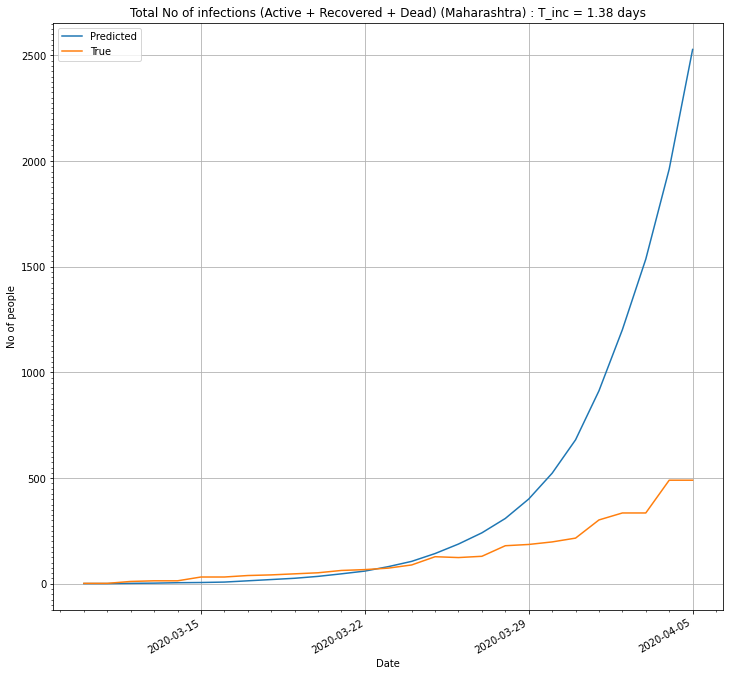

In [123]:
# Imperfecting Testing (How do the curves vary with decreasing sensitivity)

# vanilla_params, testing_params, state_init_values = init_params(N=1e9, init_infected=1)
# solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
# sol = solver.solve_ode(method='RK23')
# states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )

# vanilla_params, testing_params, state_init_values = init_params(N=1e9, init_infected=1)
# solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
# sol = solver.solve_ode(method='Radau')
# states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )

# vanilla_params, testing_params, state_init_values = init_params(N=1e9, init_infected=1)
# solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
# sol = solver.solve_ode(method='LSODA')
# states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )

# vanilla_params, testing_params, state_init_values = init_params(N=1e9, init_infected=1)
# solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
# sol = solver.solve_ode(method='BDF')
# states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )

states_time_matrices = []
vanilla_params, testing_params, state_init_values = init_params(R0=2.42, T_inc=1.38, T_inf=3, N=1.12374333e8, init_infected=2)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(time_step=1, method='Radau')
states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )

last_time = 27
# create_plots(sol, np.array(states_time_matrices)[:, :, :last_time], labels = ['Radau'], last_time=last_time, savefig=False, filenames=None)

ind = sol.t[:last_time]
states_time_matrix = np.array(states_time_matrices)[0, :, :last_time]
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(np.array(df[df['loc'] == 'Maharashtra']['date']), states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
         states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
         states_time_matrix[9] + states_time_matrix[10], label='Predicted')
ax.plot(np.array(df[df['loc'] == 'Maharashtra']['date']), df[df['loc'] == 'Maharashtra']['confirmedCases'], label='True')
ax.yaxis.set_minor_locator(plt.MultipleLocator(25))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.ylabel('No of people')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.title("Total No of infections (Active + Recovered + Dead) (Maharashtra) : T_inc = 1.38 days")
plt.show()

In [ ]:
states_time_matrices = []
vanilla_params, testing_params, state_init_values = init_params(R0=2.38, T_inf=1, N=1.6787941e7, init_infected=2)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(time_step=1, method='Radau')
states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )

last_time = 27
# create_plots(sol, np.array(states_time_matrices)[:, :, :last_time], labels = ['Radau'], last_time=last_time, savefig=False, filenames=None)

ind = sol.t[:last_time]
states_time_matrix = np.array(states_time_matrices)[0, :, :last_time]
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df[df['loc'] == 'Delhi']['date'], states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
         states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
         states_time_matrix[9] + states_time_matrix[10], label='Predicted')
ax.plot(df[df['loc'] == 'Delhi']['date'], df[df['loc'] == 'Delhi']['confirmedCases'], label='True')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of people')
plt.xlabel('Days')
plt.legend()
plt.title("Total No of infections (Active + Recovered + Dead) (Delhi)")
plt.show()


In [12]:
import scipy
scipy.__version__

from platform import python_version

print(python_version())

2.7.15+


In [72]:
np.array(states_time_matrices)[:, :, :13].shape

(5, 11, 13)

In [55]:
vanilla_params

{'N': 112374333,
 'P_fatal': 0.02,
 'P_mild': 0.78,
 'P_severe': 0.2,
 'T_death': 32,
 'T_hosp': 5,
 'T_inc': 5.2,
 'T_inf': 2.9,
 'T_recov_mild': 11.1,
 'T_recov_severe': 28.6,
 'T_trans': 1.3181818181818181,
 'intervention_amount': 3,
 'intervention_day': 100}